<a href="https://colab.research.google.com/github/julianVelandia/RedesNeuronalesConPyTorch/blob/master/redes-neuronales-convolucionales/4_3_Proyecto_de_Redes_Neuronales_Convolucionales_FULL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Redes Neuronales Convolucionales con PyTorch

## Introducción
Vamos a construir y entrenar una red neuronal convolucional (CNN) utilizando PyTorch que clasifica dígitos escritos a mano del dataset MNIST.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

## Preparación de los Datos
Descargaremos el dataset MNIST y lo prepararemos para su uso en PyTorch. Utilizaremos transformaciones para normalizar las imágenes a valores entre 0 y 1.

In [ ]:
# dataset

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 14012247.40it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 483863.43it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4346375.22it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5774637.40it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Exploración de los Datos
Vamos a explorar el dataset MNIST visualizando algunas imágenes y sus respectivas etiquetas.

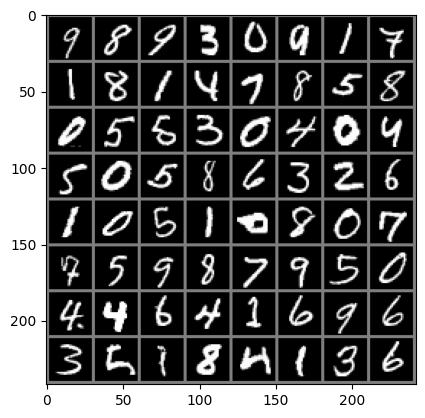

Etiquetas:
9
9 8 9 3 0 9 1 7
1 8 1 4 7 8 5 8
0 5 5 3 0 4 0 4
5 0 5 8 6 3 2 6
1 0 5 1 0 8 0 7
7 5 9 8 7 9 5 0
4 4 6 4 1 6 9 6
3 5 1 8 4 1 3 6


In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

def imshow(img):
    """Muestra una imagen normalizada."""
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
print('Etiquetas:')
print(labels[0].item())
for i in range(0, len(labels), 8):
    print(' '.join(f'{labels[j].item()}' for j in range(i, min(i+8, len(labels)))))

## Definición de la Red Neuronal Convolucional
Aquí definimos nuestra CNN. Usaremos dos capas convolucionales seguidas de capas completamente conectadas.


1. **Entrada**: La imagen de MNIST tiene dimensiones **28x28** y 1 canal.
   
2. **Convolución 1**: Con kernel `5x5`, padding `2` y stride `1`, mantiene el tamaño en **28x28**. La salida tiene 16 canales.
   
3. **Max pooling 1**: Reduce el tamaño de **28x28** a **14x14**.

4. **Convolución 2**: Mantiene el tamaño en **14x14**. La salida tiene 32 canales.

5. **Max pooling 2**: Reduce el tamaño de **14x14** a **7x7**.

6. **Aplanado**: El tensor `32x7x7` se aplana a un vector de tamaño **32 * 7 * 7 = 1568** para la capa totalmente conectada.


In [ ]:
class CNN(nn.Module):
    """Red Neuronal Convolucional simple para MNIST."""

    def __init__(self):
        super(CNN, self).__init__()
        # Primera capa convolucional: toma una imagen y produce 16 mapas de características
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        # Segunda capa convolucional: toma los 16 mapas de características y produce 32 mapas de características
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        # Primera capa FC: aplana las características 32x7x7 a un vector y produce 32 unidades
        self.fc1 = nn.Linear(32*7*7, 32)
        # Segunda capa FC: toma las 32 unidades y produce la salida final de 10 clases
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        """Paso hacia adelante en la red."""
        # Primera convolución, y función de activación ReLU
        x = F.relu(self.conv1(x))
        # Se reduce la dimensionalidad usando max pooling (ventana 2x2)
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Aplanamos el tensor
        x = torch.flatten(x, start_dim=1)

        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        return x

model = CNN()

## Instanciar la Red y Definir el Optimizer
Instanciamos la red, definimos la función de pérdida (cross-entropy) y el optimizador (Adam).

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

## Entrenamiento y Evaluación de la CNN
Entrenamos la red por 5 épocas. Para cada lote, calculamos la pérdida, realizamos la retropropagación y actualizamos los pesos.

In [ ]:

n_epochs = 5

for epoch in range(n_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

Epoch 1, Loss: 0.16392170994265526
Epoch 2, Loss: 0.07943818912023991
Epoch 3, Loss: 0.07463353952108227
Epoch 4, Loss: 0.07333470164882099
Epoch 5, Loss: 0.07196038849695872


## Evaluación del Modelo
Evaluamos el modelo en el conjunto de prueba y calculamos la precisión.

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Correctos: {correct}")
print(f"Total: {total}")

Correctos: 9773
Total: 10000


## Visualización de Resultados
Mostramos algunas predicciones del modelo junto con sus etiquetas reales para evaluar visualmente el desempeño.

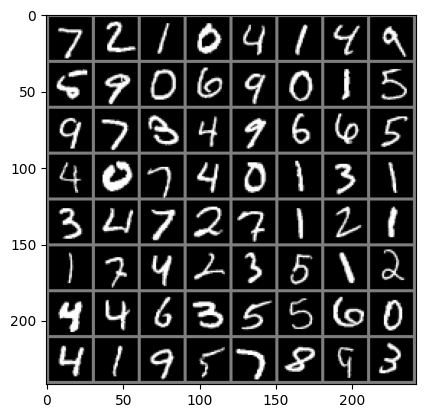

Predicted:
7 2 1 0 4 1 4 9
5 9 0 6 9 0 1 5
9 7 3 4 9 6 6 5
4 0 7 4 0 1 3 1
3 4 7 2 7 1 2 1
1 7 4 2 3 5 1 2
4 4 6 3 5 5 6 0
4 1 9 5 7 8 9 3
GroundTruth:
7 2 1 0 4 1 4 9
5 9 0 6 9 0 1 5
9 7 3 4 9 6 6 5
4 0 7 4 0 1 3 1
3 4 7 2 7 1 2 1
1 7 4 2 3 5 1 2
4 4 6 3 5 5 6 0
4 1 9 5 7 8 9 3


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

imshow(torchvision.utils.make_grid(images))

print('Predicted:')
for i in range(0, len(predicted), 8):
    print(' '.join(f'{predicted[j].item()}' for j in range(i, min(i + 8, len(predicted)))))

print('GroundTruth:')
for i in range(0, len(labels), 8):
    print(' '.join(f'{labels[j].item()}' for j in range(i, min(i + 8, len(labels)))))
